In [15]:
import tensorflow as tf

# --- Rutas ---
train_dir = "C:/Users/aserr/Downloads/002.Cancer/train"
test_dir  = "C:/Users/aserr/Downloads/002.Cancer/test"

# --- Parámetros ---
img_height, img_width = 224, 224
batch_size = 32

# --- Preprocesamiento ---
def preprocess_tensor(img, label):
    # Redimensionar
    img = tf.image.resize(img, [img_height, img_width])
    # Normalizar a [0,1]
    img = img / 255.0
    return img, label

# --- Dataset de entrenamiento + validación ---
full_train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="int",
    batch_size=None,  # sin batching para poder separar
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123
)

# Split en train y validación (80/20)
train_size = int(0.8 * len(full_train_ds))
val_size = len(full_train_ds) - train_size

train_ds = full_train_ds.take(train_size)
val_ds   = full_train_ds.skip(train_size)

# Preprocesar
train_ds = train_ds.map(preprocess_tensor, num_parallel_calls=tf.data.AUTOTUNE)
val_ds   = val_ds.map(preprocess_tensor, num_parallel_calls=tf.data.AUTOTUNE)

# Batch + Prefetch
train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# --- Dataset de test ---
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="int",
    batch_size=None,
    image_size=(img_height, img_width),
    shuffle=False
)
test_ds = test_ds.map(preprocess_tensor, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

print("✅ Train, validación y test listos")


Found 11879 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
✅ Train, validación y test listos


## 1. CNN Sencilla

In [16]:
from tensorflow import keras
from tensorflow.keras import layers

# --- Definir modelo CNN simple ---
model = keras.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # salida binaria (maligno/benigno)
])

# --- Compilar ---
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# --- Entrenar ---
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

# --- Evaluar en test ---
test_loss, test_acc = model.evaluate(test_ds)
print(f"✅ Precisión en test: {test_acc:.2f}")


Epoch 1/10


c:\Users\aserr\Documents\GitHub\Caso1_Detenci-n_de_melanomas\env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


297/297 ━━━━━━━━━━━━━━━━━━━━ 65s 215ms/step - accuracy: 0.7630 - loss: 0.5073 - val_accuracy: 0.8165 - val_loss: 0.3721
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 65s 220ms/step - accuracy: 0.8252 - loss: 0.3970 - val_accuracy: 0.8190 - val_loss: 0.3842
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 61s 205ms/step - accuracy: 0.8384 - loss: 0.3720 - val_accuracy: 0.8628 - val_loss: 0.3328
Epoch 4/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 62s 210ms/step - accuracy: 0.8459 - loss: 0.3565 - val_accuracy: 0.8519 - val_loss: 0.3378
Epoch 5/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 61s 205ms/step - accuracy: 0.8493 - loss: 0.3475 - val_accuracy: 0.8468 - val_loss: 0.3280
Epoch 6/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 61s 205ms/step - accuracy: 0.8574 - loss: 0.3338 - val_accuracy: 0.8666 - val_loss: 0.3127
Epoch 7/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 60s 203ms/step - accuracy: 0.8562 - loss: 0.3215 - val_accuracy: 0.8708 - val_loss: 0.3030
Epoch 8/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 60s 203ms/step - accuracy: 0.8571 - loss: 0.3201 - val

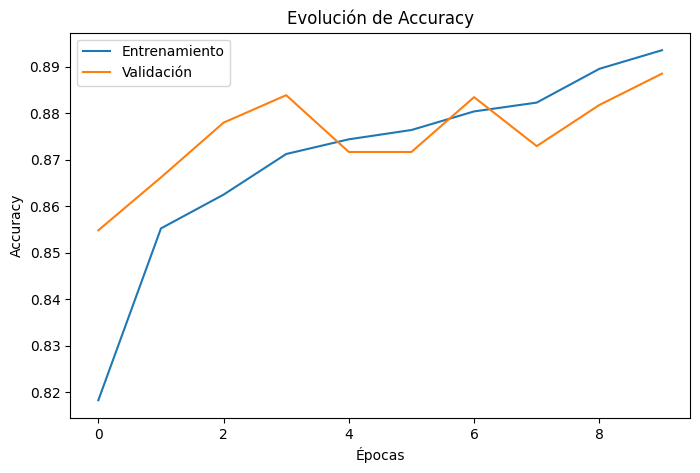

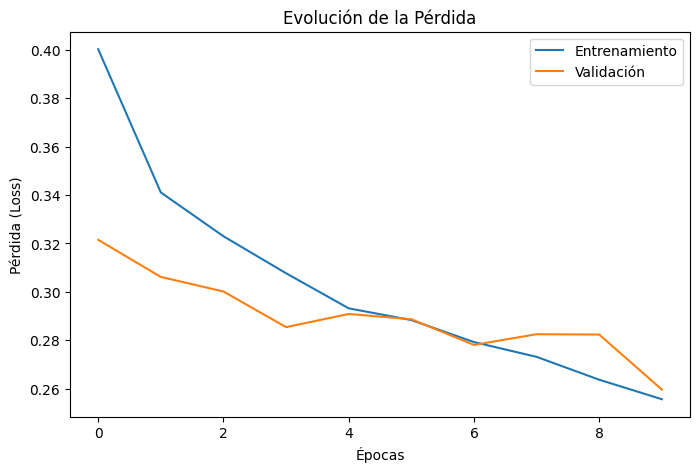

In [19]:
import matplotlib.pyplot as plt

# --- Curvas de Accuracy ---
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.title('Evolución de Accuracy')
plt.legend()
plt.show()

# --- Curvas de Loss ---
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (Loss)')
plt.title('Evolución de la Pérdida')
plt.legend()
plt.show()


## 2. Transfer Learning (más potente)

In [17]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

# --- Base preentrenada ---
base_model = MobileNetV2(input_shape=(img_height, img_width, 3),
                         include_top=False,
                         weights='imagenet')

base_model.trainable = False  # congelar capas

# --- Modelo completo ---
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# --- Compilar ---
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# --- Entrenar ---
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

# --- Evaluar ---
test_loss, test_acc = model.evaluate(test_ds)
print(f"✅ Precisión en test: {test_acc:.2f}")


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 65s 213ms/step - accuracy: 0.8183 - loss: 0.4003 - val_accuracy: 0.8548 - val_loss: 0.3215
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 62s 209ms/step - accuracy: 0.8552 - loss: 0.3411 - val_accuracy: 0.8662 - val_loss: 0.3062
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 62s 209ms/step - accuracy: 0.8625 - loss: 0.3230 - val_accuracy: 0.8779 - val_loss: 0.3002
Epoch 4/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 62s 208ms/step - accuracy: 0.8712 - loss: 0.3077 - val_accuracy: 0.8838 - val_loss: 0.2854
Epoch 5/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 62s 207ms/step - accuracy: 0.8744 - loss: 0.2932 - val_accuracy: 0.8716 - val_loss: 0.2909
Epoch 6/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 62s 207ms/step - accuracy: 0.8764 - loss: 0.2883 - val_accuracy: 0.8716 - val_loss: 0.2887
Epoch 7/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 62s 209ms/step - accuracy: 0.8804 - loss: 0.2792 - val_accuracy: 0.8834 - val_loss: 0.2781
Epoch 8/10
297/297 ━━━━━━━━━━━━━━━

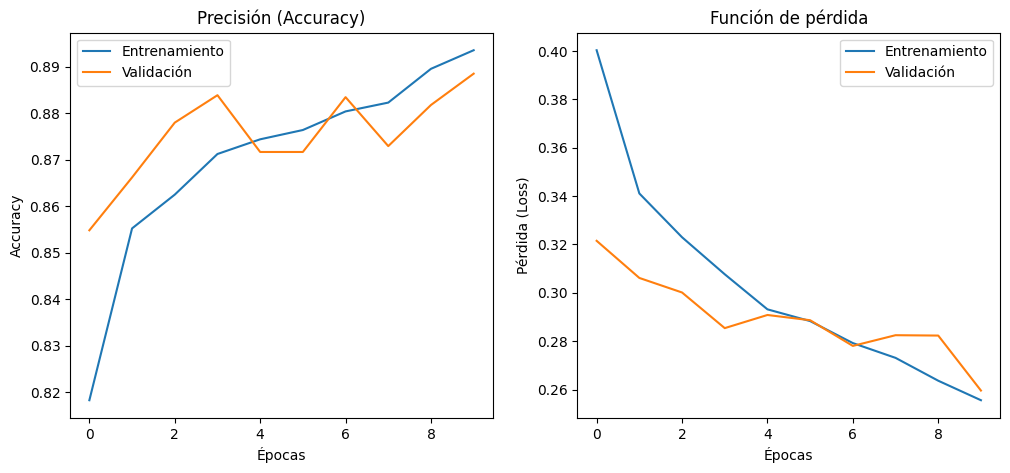

63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 184ms/step


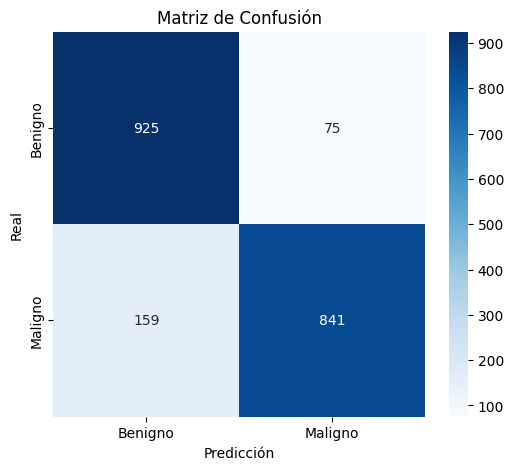

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# --- Gráfico de Accuracy y Loss ---
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.title("Precisión (Accuracy)")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.xlabel("Épocas")
plt.ylabel("Pérdida (Loss)")
plt.title("Función de pérdida")
plt.legend()

plt.show()

# --- Matriz de confusión ---
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_prob = model.predict(test_ds)
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benigno", "Maligno"],
            yticklabels=["Benigno", "Maligno"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()
